In [ ]:
# Getting the Dataset :
# https://drive.google.com/file/d/1oJSY4yQvGhi391qBzf1g2QGWi25n1ryl/view?usp=drive_link
!wget -O gan_train.h5 --no-check-certificate "https://docs.google.com/uc?export=download&id=1oJSY4yQvGhi391qBzf1g2QGWi25n1ryl&confirm=t"

--2023-12-02 04:12:39--  https://docs.google.com/uc?export=download&id=1oJSY4yQvGhi391qBzf1g2QGWi25n1ryl&confirm=t
Resolving docs.google.com (docs.google.com)... 172.253.117.101, 172.253.117.100, 172.253.117.138, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8rhpgathf72m2bgob9tp41i6ot36k2jj/1701490350000/10708217807803813109/*/1oJSY4yQvGhi391qBzf1g2QGWi25n1ryl?e=download&uuid=772e8edc-29aa-4301-ae5a-13b73934f68e [following]
--2023-12-02 04:12:39--  https://doc-10-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/8rhpgathf72m2bgob9tp41i6ot36k2jj/1701490350000/10708217807803813109/*/1oJSY4yQvGhi391qBzf1g2QGWi25n1ryl?e=download&uuid=772e8edc-29aa-4301-ae5a-13b73934f68e
Resolving doc-10-58-docs.googleusercontent.com (doc-10-58-docs.googleusercontent.com)... 172.253.117.

In [ ]:
import h5py

with h5py.File('gan_train.h5','r') as hf:
  print(hf.keys())

<KeysViewHDF5 ['corrupted_images', 'image_names', 'original_images']>


In [ ]:
import torch

with h5py.File('gan_train.h5','r') as hf:
  original_images_dataset = hf['original_images']
  corrupted_images_dataset = hf['corrupted_images']
  image_names_dataset = hf['image_names']

  original_images_data = original_images_dataset[:]
  corrupted_images_data = corrupted_images_dataset[:]
  labels = image_names_dataset[:]

original_images = torch.from_numpy(original_images_data)
corrupted_images = torch.from_numpy(corrupted_images_data)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.image as mpimg
import numpy as np

def display_images(dataset,n):
    num_images = n
    rows = int(np.ceil(num_images / 5))
    fig = plt.figure(figsize=(15, 3 * rows))
    gs = gridspec.GridSpec(rows, 5, width_ratios=[1]*5)

    for i in range(num_images):
        img = dataset[i]
        ax = plt.subplot(gs[i])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{labels[i]}')
    plt.tight_layout()
    plt.show()


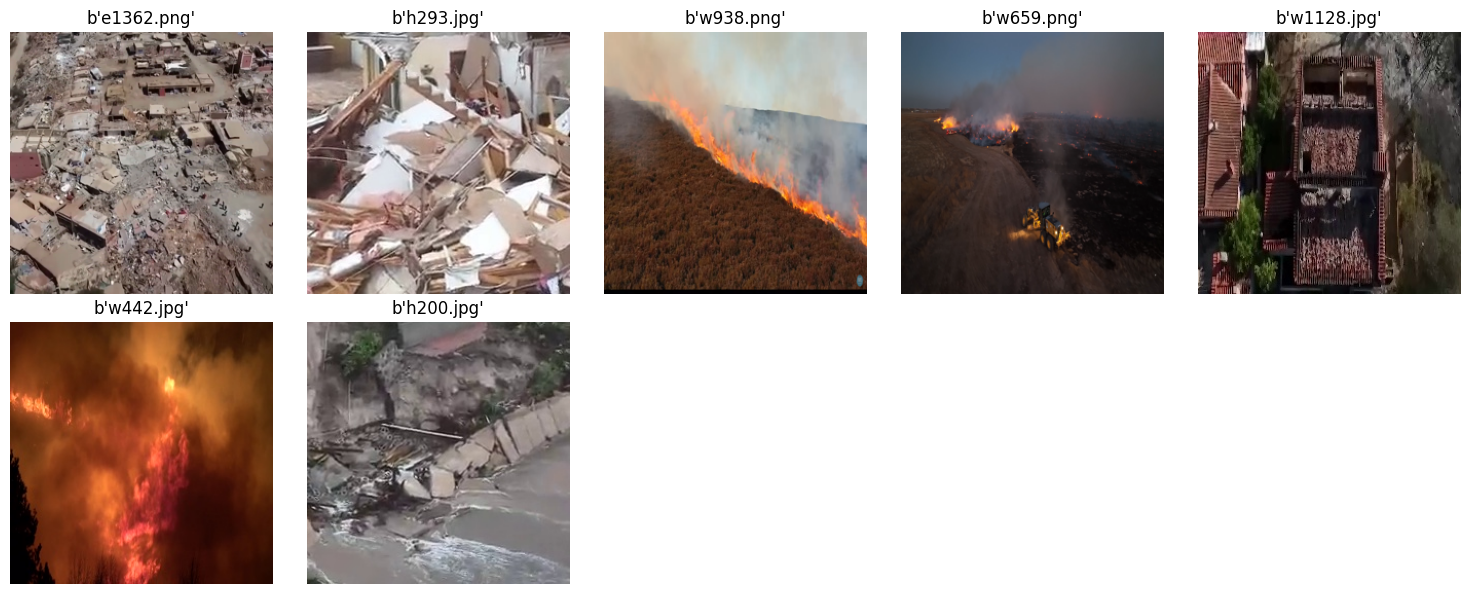

In [ ]:
display_images(original_images,7)

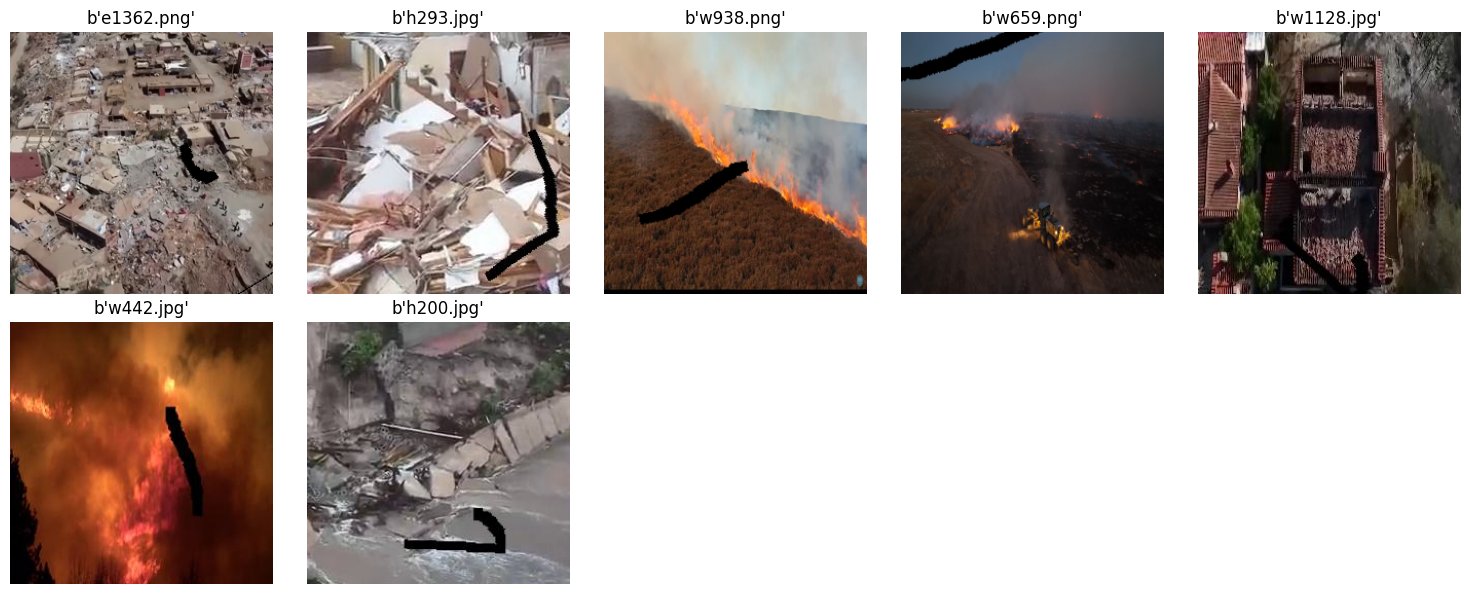

In [ ]:
display_images(corrupted_images,7)

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1), # 128,128,64
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 64,64,128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)



class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 3, stride=1, padding=1),  # Changed stride from 1 to padding from 1 to maintain spatial dimensions
            nn.AdaptiveAvgPool2d(1)  # Global average pooling
        )

    def forward(self, x):
        # Your forward pass logic here
        x = self.model(x)
        return torch.sigmoid(x.view(x.size(0), -1))  # Flatten to 1D tensor and apply sigmoid


In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

cuda = True if torch.cuda.is_available() else False

lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
tensor_permuted = original_images[3].permute(2, 0, 1)
print(tensor_permuted.shape)

torch.Size([3, 256, 256])


In [ ]:
# Custom dataset
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class OriginalCorruptedDataset(Dataset):
    def __init__(self, original_images, corrupted_images, transform=None):
        self.original_images = original_images
        self.corrupted_images = corrupted_images
        self.transform = transform

    def __len__(self):
        return len(self.original_images)

    def __getitem__(self, idx):
        original_image = self.original_images[idx]
        corrupted_image = self.corrupted_images[idx]

        if self.transform:
            original_image = self.transform(original_image)
            corrupted_image = self.transform(corrupted_image)

        return original_image, corrupted_image

# Example usage
# Assuming you have 'original_images' and 'corrupted_images' tensors

# Define transformations if needed
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Convert images to PyTorch tensors
#     # Add other transformations if needed
# ])

# Instantiate the dataset
original_corrupted_dataset = OriginalCorruptedDataset(original_images, corrupted_images)


In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(original_corrupted_dataset, batch_size=32, shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming you have defined Generator and Discriminator classes
# You also need to have a dataset and appropriate data loading code

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
lr = 0.0001
beta1 = 0.5
epochs = 30
batch_size = 43

# Instantiate Generator and Discriminator and move to GPU
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)




# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Assuming you have a DataLoader named 'dataloader'
# Make sure that the dataset is also moving the data to GPU if applicable

# Training loop
for epoch in range(epochs):
    for i, data in enumerate(dataloader):
        original_images, corrupted_images = data

        # Move data to GPU
        original_images = original_images.to(device)
        corrupted_images = corrupted_images.to(device)

        # Train Discriminator with real data
        optimizer_d.zero_grad()

        output_real = discriminator(original_images.permute(0, 3, 1, 2).float())
        real_labels = torch.ones(output_real.size(0), 1, device=device)
        loss_real = criterion(output_real, real_labels)
        loss_real.backward()

        # Train Discriminator with fake data
        z = corrupted_images.permute(0, 3, 1, 2).float()
        fake_data = generator(z)

        output_fake = discriminator(fake_data.detach())
        fake_labels = torch.zeros(output_fake.size(0), 1, device=device)
        loss_fake = criterion(output_fake, fake_labels)
        loss_fake.backward()

        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        output_generated = discriminator(fake_data)
        loss_generator = criterion(output_generated, real_labels)

        loss_generator.backward()
        optimizer_g.step()

        # Print loss statistics
        if i % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], Batch [{i}/{len(dataloader)}], '
                  f'Discriminator Loss: {loss_real.item() + loss_fake.item()}, '
                  f'Generator Loss: {loss_generator.item()}')

# Save the trained models if needed
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


Epoch [0/30], Batch [0/172], Discriminator Loss: 1.4265912175178528, Generator Loss: 0.9168974161148071
Epoch [0/30], Batch [100/172], Discriminator Loss: 0.04085303843021393, Generator Loss: 3.9935107231140137
Epoch [1/30], Batch [0/172], Discriminator Loss: 0.013982254546135664, Generator Loss: 4.774714469909668
Epoch [1/30], Batch [100/172], Discriminator Loss: 0.0073798601515591145, Generator Loss: 5.463271617889404
Epoch [2/30], Batch [0/172], Discriminator Loss: 0.005623646313324571, Generator Loss: 5.751299858093262
Epoch [2/30], Batch [100/172], Discriminator Loss: 0.0037896938156336546, Generator Loss: 6.1821489334106445
Epoch [3/30], Batch [0/172], Discriminator Loss: 0.0028512448770925403, Generator Loss: 6.428317070007324
Epoch [3/30], Batch [100/172], Discriminator Loss: 0.002249647048301995, Generator Loss: 6.642091274261475
Epoch [4/30], Batch [0/172], Discriminator Loss: 0.0019410779350437224, Generator Loss: 6.7925872802734375
Epoch [4/30], Batch [100/172], Discriminat

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have defined the Generator class and tensor_permuted as mentioned earlier

# Instantiate the generator
# generator = Generator()

# Assuming tensor_permuted has shape [3, 256, 256]
input_tensor = tensor_permuted.unsqueeze(0).float()

# Generate an output image
output_image = generator(input_tensor.to(device))

# Convert the output tensor to a NumPy array and transpose dimensions
output_image_np = output_image.squeeze().cpu().detach().numpy().transpose((1, 2, 0))

# Display the original and generated images
plt.subplot(1, 2, 1)
plt.imshow(corrupted_images[1].cpu().numpy())
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(output_image_np)
plt.title('Generated Image')
print(output_image_np.shape)
plt.show()